# Using Data Science to Win at Fantasy Football

## Taught By Alex Cates


## What is Data Science?

For me, Data Science is a method of answering questions based on historical data, statistics, simulations, and predictions.  All of that being said, 90% of data science consists of designing your question, quantifying your variables, and collecting the data.

### Importantly, Data Science can be done without any advanced mathematics

All of the math that I will cover today would be taught in a high school statistics class.  The real magic of data science is not in fancy mathematics, but well posed questions

## Why Fantasy Football

Fantasy football offers an excellent test bed to explore data science.  There are lots of fun questions that can be asked and, with careful data processing, answered.  The data is relatively straight forward and there are a few straight forward outcome measures to optimize towards (points, wins, final standing, etc.)

In [1]:
import pandas as pd
import numpy as np
import pickle
from espn_api.football import League

df = pd.read_csv('player_performance_2019.csv')
df.head()

,Unnamed: 0,week,player,player_id,proteam,position,points,proj_points,fteam
0,8,0,Ravens D/ST,-16033,BAL,D/ST,6.0,6.82,1
1,12,0,Broncos D/ST,-16007,DEN,D/ST,8.0,8.84,1
2,31,0,Vikings D/ST,-16016,MIN,D/ST,8.0,5.06,2
3,44,0,Saints D/ST,-16018,NO,D/ST,5.0,6.50,3
4,54,0,Rams D/ST,-16014,LAR,D/ST,9.0,5.18,4


# VORP, VOSP, and VOBP

## Value over Replacement

The most important concept to help you win is the idea of value over replacement player.  You may have heard of the idea of using tiers instead of rankings, and that is entirely based on value over replacemet.

Simply put, value over replacement is how many points a player scored compared to what their replacement would score.

So what is a replacement player?

There are 3 types of replacement players that matter for Fantasy Football

1. Free agents (VORP)
2. Non-Starter Caliber (VOSP)
3. Your Bench Players (VOBP)

lets define them one at a time

## VORP - Value Over Free Agents

To calculate a player's VORP, we use the following equation

Points scored by player - points scored by the best free agent at same position

we can do that for each week to account for changing free agents

In [2]:
replacement_dict = {}
for w, wdf in df.groupby('week'):
    replacement_dict[w] = {}
    for p, pdf in wdf.groupby('position'):
        best_free_agent = pdf[pdf.fteam == 0].points.max()
        replacement_dict[w][p] = best_free_agent
        
print(replacement_dict[5])

    

{'D/ST': 10.0, 'K': 16.0, 'QB': 27.26, 'RB': 14.6, 'TE': 14.0, 'WR': 16.3}


In [3]:
df['vorp'] = df.apply(lambda x: x.points - replacement_dict[x.week][x.position], axis = 1)

df.sort_values('vorp', ascending = False).head(10)

,Unnamed: 0,week,player,player_id,proteam,position,points,proj_points,fteam,vorp
3370,3264,5,Aaron Jones,3042519,GB,RB,42.2,12.05,9,27.6
3329,3132,5,Christian McCaffrey,3117251,CAR,RB,41.7,18.16,3,27.1
5243,5154,8,Tevin Coleman,2979477,SF,RB,35.8,13.10,5,26.9
5223,5080,8,Aaron Jones,3042519,GB,RB,34.6,13.76,9,25.7
4620,4528,7,Chase Edmonds,3119195,ARI,RB,33.0,4.80,5,25.6
3126,3226,5,Eagles D/ST,-16021,PHI,D/ST,35.0,10.39,1,25.0
9571,9415,15,Kenyan Drake,2979843,ARI,RB,38.6,10.91,3,24.4
1250,1294,2,Patriots D/ST,-16017,NE,D/ST,35.0,6.35,5,24.0
3643,3272,5,Will Fuller V,3052876,HOU,WR,39.7,6.89,9,23.4
243,112,0,Saquon Barkley,3929630,NYG,RB,39.9,15.10,8,23.3


In [4]:
new_replacement_dict = {}
for w, wdf in df.groupby('week'):
    new_replacement_dict[w] = {}
    for p, pdf in wdf.groupby('position'):
        best_free_agent = pdf[(pdf.fteam == 0)].sort_values('proj_points', ascending = False).iloc[0]['points']
        new_replacement_dict[w][p] = best_free_agent
        
print(new_replacement_dict[6])
        
df['vorp'] = df.apply(lambda x: x.points - new_replacement_dict[x.week][x.position], axis = 1)

df.sort_values('vorp', ascending = False).head(10)

{'D/ST': 0.0, 'K': 4.0, 'QB': 13.6, 'RB': 1.5, 'TE': 0.9, 'WR': 5.3}


,Unnamed: 0,week,player,player_id,proteam,position,points,proj_points,fteam,vorp
3370,3264,5,Aaron Jones,3042519,GB,RB,42.2,12.05,9,38.4
3329,3132,5,Christian McCaffrey,3117251,CAR,RB,41.7,18.16,3,37.9
3126,3226,5,Eagles D/ST,-16021,PHI,D/ST,35.0,10.39,1,35.0
9571,9415,15,Kenyan Drake,2979843,ARI,RB,38.6,10.91,3,34.6
2357,1912,3,Mike Evans,16737,TB,WR,37.0,9.20,7,34.0
5865,5772,9,Christian McCaffrey,3117251,CAR,RB,34.6,19.60,3,33.1
1250,1294,2,Patriots D/ST,-16017,NE,D/ST,35.0,6.35,5,32.0
4232,3794,6,Stefon Diggs,2976212,MIN,WR,36.5,6.41,1,31.2
5243,5154,8,Tevin Coleman,2979477,SF,RB,35.8,13.10,5,31.2
3643,3272,5,Will Fuller V,3052876,HOU,WR,39.7,6.89,9,31.1


## Why is Vorp Important

We can look at the value of vorp by comparing how a the total vorp of a fantasy team relates to where that team finished

In [10]:
vorp_df = pd.read_csv('vorp_splash.csv')
vorp_df.head()


,Unnamed: 0,lid,team,week,vosp,vorp,reg_standing,final_standing,score,outcome
0,0,38734302,Anthony Vlahos,0,41.76,17.10,10,11,156.52,True
1,1,38734302,Anthony Vlahos,1,98.72,86.31,10,11,87.82,False
2,2,38734302,Anthony Vlahos,2,6.72,-1.24,10,11,134.62,True
3,3,38734302,Anthony Vlahos,3,26.90,-50.77,10,11,115.84,False
4,4,38734302,Anthony Vlahos,4,-1.26,-0.05,10,11,132.12,False


(0, 16)

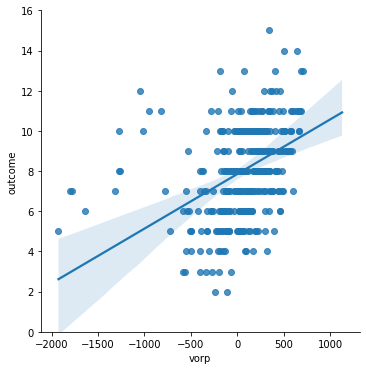

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

team_vorp_df = vorp_df.groupby(['lid', 'team']).sum()
sns.lmplot(x = 'vorp', y = 'outcome', data = team_vorp_df)
plt.ylim([0,16])

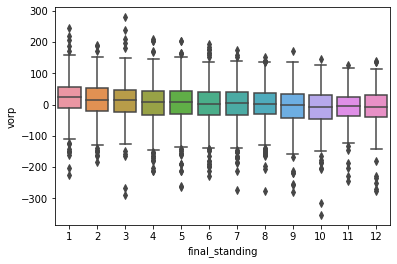

In [18]:
sns.boxplot(x = 'final_standing', y = 'vorp', data = vorp_df)

## VOSP - Value Over non-Starting Player

VOSP or value over starting player is calculated the same as vorp, but instead of the replacement level player being the best free agent, we can define that as the next replacement for a starter caliber player of the week.

For instance, In a 10 team league which starts 1 QB, the 11th best QB of the week would define our replacement level.

We can do the same calculations as above

In [32]:
vosp_replacement_dict = {}
for w, wdf in df.groupby('week'):
    vosp_replacement_dict[w] = {}
    for p, pdf in wdf.groupby('position'):
        if p in ['QB', 'TE', 'D/ST', 'K']:
            best_nonstarter = pdf.sort_values('points', ascending = False).iloc[11]['points']
            vosp_replacement_dict[w][p] = best_nonstarter
        elif p in ['RB', 'WR']:
            best_nonstarter = pdf.sort_values('points', ascending = False).iloc[21]['points']
            vosp_replacement_dict[w][p] = best_nonstarter
        
print(vosp_replacement_dict[6])
        
df['vosp'] = df.apply(lambda x: x.points - vosp_replacement_dict[x.week][x.position], axis = 1)

df.sort_values('vosp', ascending = False).head(10)

{'D/ST': 5.0, 'K': 6.0, 'QB': 18.22, 'RB': 8.5, 'TE': 5.2, 'WR': 7.6}


,week,player,player_id,proteam,position,points,proj_points,fteam,vorp,vosp
3264,5,Aaron Jones,3042519,GB,RB,42.2,12.05,9,38.4,31.28
3272,5,Will Fuller V,3052876,HOU,WR,39.7,6.89,9,31.1,30.80
3132,5,Christian McCaffrey,3117251,CAR,RB,41.7,18.16,3,37.9,30.78
3226,5,Eagles D/ST,-16021,PHI,D/ST,35.0,10.39,1,35.0,30.00
9415,15,Kenyan Drake,2979843,ARI,RB,38.6,10.91,3,34.6,29.70
3794,6,Stefon Diggs,2976212,MIN,WR,36.5,6.41,1,31.2,28.90
112,0,Saquon Barkley,3929630,NYG,RB,39.9,15.10,8,23.3,28.80
1294,2,Patriots D/ST,-16017,NE,D/ST,35.0,6.35,5,32.0,28.00
632,1,Sammy Watkins,16725,KC,WR,37.8,7.06,9,22.1,27.42
4528,7,Chase Edmonds,3119195,ARI,RB,33.0,4.80,5,30.1,26.60


Text(9.924999999999997, 0.5, 'wins')

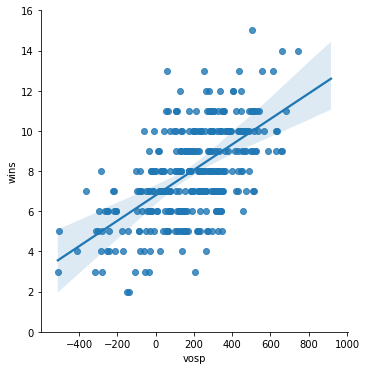

In [23]:
sns.lmplot(x = 'vosp', y = 'outcome', data = team_vorp_df)
plt.ylim([0,16])
plt.ylabel('wins')

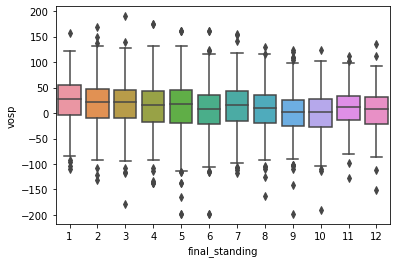

In [24]:
sns.boxplot(x = 'final_standing', y = 'vosp', data = vorp_df)

## Is VORP or VOSP more important?

While Vorp is a measure of how good the entire team is, the entire team does not score.  For VOSP, you want your starting lineup to be positive vosp.  VOSP vs VORP is the debate of if you want a shallow high end team (High VOSP) or a balanced deep team (High Vorp).  Obviously you want both but most teams can't get that, so which is better? 

One way to look at this is to simply run a linear regression and see which is weighted more.  A linear regression will create a multidimensional line that predicts the outcome measures based on the inputs.  In this case, lets use a teams total VORP, VOSP, and Points For over the course of the season, and see well we can predict that teams final standing:

In [25]:
import pingouin as pg

pov = pg.linear_regression(team_vorp_df[['vorp', 'vosp']], team_vorp_df.outcome, relimp = True)
print(pov.round(2))

       names  coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]  \
0  Intercept  6.92  0.18  38.55  0.00  0.26    0.26      6.57       7.28   
1       vorp  0.00  0.00   2.40  0.02  0.26    0.26      0.00       0.00   
2       vosp  0.01  0.00   7.62  0.00  0.26    0.26      0.00       0.01   

   relimp  relimp_perc  
0     NaN          NaN  
1    0.08        29.19  
2    0.19        70.81  


C:\Users\alext\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.6, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


We can see that VOSP is more important than VORP.  Now this does not mean that VORP cant predict the number of wins a team has, rather that it does not add value to a prediction when you already have VOSP.  

In short, The goal is to have the best starting lineup, depth can help you get there, but end of the day it is the starters that matters.

## VOBP - Value Over Bench Player

VOBP is really useful to assessing the depth of a team, which is necessary for trades.  To calculate a player's VOBP, you take the points that a starting player scores and subtract the points that the best bench player at that position on that fantasy team scores.  This means that a players VOBP changes from fantasy team to fantasy team.

As an example we can look at 2 teams in a given week

In [33]:
vobp_replacement_dict = {}
ddf = df[df.fteam != 0].copy()
for w, wdf in ddf.groupby('week'):
    vobp_replacement_dict[w] = {}
    for t, tdf in wdf.groupby('fteam'):
        vobp_replacement_dict[w][t] = {}
        for p, pdf in tdf.groupby('position'):
            if p in ['QB', 'TE', 'D/ST', 'K']:
                if len(pdf) > 1:
                    best_bench = pdf.sort_values('points', ascending = False).iloc[1]['points']
                    vobp_replacement_dict[w][t][p] = best_bench
                else:
                    best_bench = df[(df.week == 5) & (df.fteam == 0) & (df.position == p)].points.max()
                    vobp_replacement_dict[w][t][p] = best_bench
            elif p in ['RB', 'WR']:
                if len(pdf) > 2:
                    best_bench = pdf.sort_values('points', ascending = False).iloc[2]['points']
                    vobp_replacement_dict[w][t][p] = best_bench
                else:
                    best_bench = df[(df.week == 5) & (df.fteam == 0) & (df.position == p)].points.max()
                    vobp_replacement_dict[w][t][p] = best_bench
        
print(vobp_replacement_dict[3][1])
        
ddf['vobp'] = ddf.apply(lambda x: x.points - vobp_replacement_dict[x.week][x.fteam][x.position], axis = 1)
print(df.columns)



{'D/ST': 10.0, 'K': 16.0, 'QB': 27.26, 'RB': 8.8, 'TE': 14.0, 'WR': 15.9}
Index(['Unnamed: 0', 'week', 'player', 'player_id', 'proteam', 'position',
       'points', 'proj_points', 'fteam', 'vorp'],
      dtype='object')


In [35]:
ddf[(ddf.week == 3) & (ddf.fteam == 2)][['player', 'position', 'vorp', 'vobp']]

,player,position,vorp,vobp
1881,Panthers D/ST,D/ST,17.00,4.00
1911,Robbie Gould,K,-3.00,-10.00
1974,Deshaun Watson,QB,6.40,4.18
1975,Carson Wentz,QB,2.22,0.00
2120,Todd Gurley II,RB,-8.60,0.00
2121,Leonard Fournette,RB,-3.70,4.90
2122,Mark Ingram II,RB,18.60,27.20
2236,Evan Engram,TE,16.30,10.70
2237,O.J. Howard,TE,5.60,0.00
2385,Amari Cooper,WR,17.80,8.40


In [41]:
data = []
for t in [1,2]:
    for pid in ddf[(ddf.fteam == t) & (ddf.week == 8)].player_id:
        
        pdf = ddf[(ddf.player_id == pid) & (ddf.week < 8)]
        try:
            row = [t, pdf.iloc[0].player, pdf.iloc[0].position, pdf.vorp.sum(), pdf.vobp.sum()]
            data.append(row)
        except:
            continue
        
trade_df = pd.DataFrame(data = data, columns = ['team', 'player', 'position', 'vorp', 'vobp'])

print(trade_df)

    team             player position   vorp   vobp
0      1      Steelers D/ST     D/ST -22.00   0.00
1      1        Mike Nugent        K   3.00 -28.00
2      1      Lamar Jackson       QB  51.04  -3.10
3      1         Josh Allen       QB  -5.16 -14.80
4      1    Ezekiel Elliott       RB  63.60  45.80
5      1         Nick Chubb       RB  55.40  37.60
6      1        Sony Michel       RB  31.60  13.80
7      1        Matt Breida       RB   3.90  -8.40
8      1   Devin Singletary       RB -27.70 -45.50
9      1       Tony Pollard       RB -13.60 -36.70
10     1       Mark Andrews       TE  57.00 -17.90
11     1        Julio Jones       WR  43.00  24.70
12     1      Brandin Cooks       WR  -0.30  -4.40
13     1       Stefon Diggs       WR  36.10  17.80
14     2      Seahawks D/ST     D/ST -14.00  -4.00
15     2      Zane Gonzalez        K  11.00 -36.00
16     2     Deshaun Watson       QB  22.36  57.10
17     2       Carson Wentz       QB -12.06  12.78
18     2     Todd Gurley II    

# Value over Replacement - Team Addition

We can use the same logic to determine how strong a fantasy team is based on how it performs vs a replacement level team.

but what is a replacement level team?

In most weeks, we define a replacement level team as the median score of all teams across the league, so a team that is above replacement scored more than at least half of the other teams in the league, while a team that is below replacement scores less than half the other teams in the league.

In [50]:
team_vor_df = pd.read_csv('team_vor.csv')
team_vor_df.head()
team_vor_df.columns

Index(['Unnamed: 0', 'lid', 'week', 'tid', 'real_score', 'espn_lineup_score',
       'best_score', 'proj_score', 'opp_score', 'opp_proj_score', 'zero_count',
       'reg_standing', 'final_standing', 'real_vs_proj', 'real_vs_espn',
       'real_vs_best', 'espn_vs_best', 'coach_win', 'bad_lineup',
       'lucky_score', 'unlucky_score', 'above_median', 'score_vs_median',
       'opp_vs_median', 'luck_score', 'lucky_win', 'unluck_loss', 'standing',
       'league_size'],
      dtype='object')

## Determining Matchup Luck

One way that team value over replacement is useful is to explore the role of luck.  You can think of one version of luck as matchup luck, specifically who you have to play in a given week.  There is no defense in fantasy football, there is nothing you can do to prevent your opponent from scoring points.  So while scoring above the median should be enough to win that week, we all remember when we had the second highest score of the week, but lost because we faced the highest scoring team.

We can look across a league to see how many lucky wins or unlucky losses occured

(-85, 85)

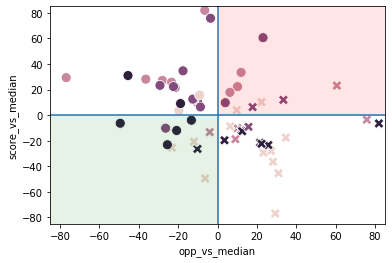

In [49]:
league_df = team_vor_df[team_vor_df.lid == 38726555].copy()
league_df.head()

plt.figure()
plt.fill([0,85,85, 0], [0,0,85,85], 'r', alpha=0.1, edgecolor='r')
plt.fill([-85,0,0, -85], [-85,-85,0, 0], 'g', alpha=0.1, edgecolor='g')
sns.scatterplot(x = 'opp_vs_median',y = 'score_vs_median', hue = 'tid', style ='coach_win', data = league_df, 
                style_order = [True, False], legend=False,
                 s = 100)
plt.axhline(0)
plt.axvline(0)
plt.xlim([-85, 85])
plt.ylim([-85, 85])

## Luck vs final standing

We can begin to explore how important luck is by comparing how many lucky wins a team gets vs where they finish

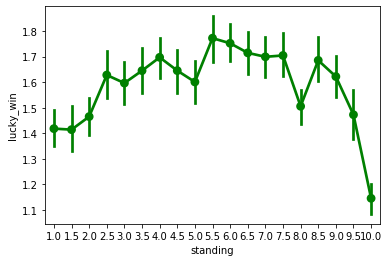

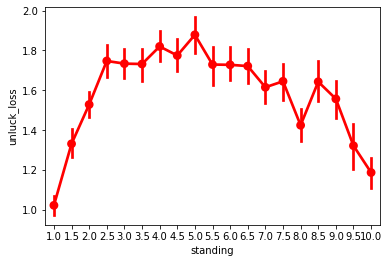

In [55]:
season_luck_df = pd.read_csv('season_luck.csv')

plt.figure()
sns.pointplot(x = 'standing', y = 'lucky_win', data = season_luck_df[season_luck_df.standing <= 10], color = 'g')


plt.figure()
sns.pointplot(x = 'standing', y = 'unluck_loss', data = season_luck_df[season_luck_df.standing <= 10], color = 'r')


## Breaking down luck even further

One way we can break matchup luck down more is thinking about how lucky a win or how unlucky a loss is.  Specifically, how many teams would you have beaten or lost to.  For example, if a team is the team is the top scoring team, there is no luck involved, they are going to win.  Whereas if they were the 3rd highest scoring team, they should win, but there are 2 teams that would have beaten them so we can give them a luck score of 2.  We can do the same with losses, ust how many teams you could beaten given your score.

We can even consolidate this as to total season long luck is by combining the luckiness of your wins and subtracting the unluckiness your losses. (this is what the luck score in the season luck file is)

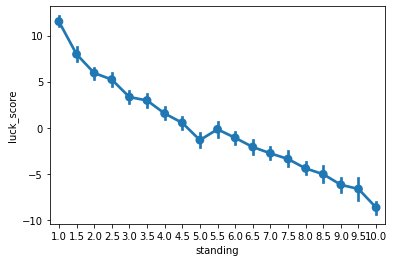

In [57]:
plt.figure()
sns.pointplot(x = 'standing', y = 'luck_score', data = season_luck_df[season_luck_df.standing <= 10])

# Conclusion

1. Try to think in terms of value above replacement when assessing the value of players and of teams. 

2. Both depth and starting lineup strength are important, but depth seems to be a better predictor

3. luck matters, but not a ton

# What to do Next?

* If interested in learning python to enable you to create these sorts of investigations, check out https://www.fantasyfootballdatapros.com/blog/beginner/1

* If you know python or want to just explore this without following a blog, The package I use to gather data from my and other fantasy football leagues can be found at https://github.com/cwendt94/espn-api

* Finally, if you just want to read more about explorations into fantasy football with data science, check out these blogs
    - https://stmorse.github.io/blog.html
    - https://www.alexcates.com/blog (this one is mine)